<a href="https://colab.research.google.com/github/eali93/Computational-Neuroscience/blob/main/CompNeuroProject_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install Libraries
!pip install numpy scipy scikit-learn --quiet
# !pip install --upgrade pandas numpy

# Import libraries
import numpy as np
import scipy
import scipy.io #enables uploading of .mat files
import matplotlib.pyplot as plt
# from sklearn.feature_selection import mutual_info_classif #for MI analysis
import math
from scipy import stats as st
from scipy import signal
from scipy import interpolate
from scipy.io import loadmat
print("Libraries loaded successfully!")


Libraries loaded successfully!


In [14]:
# Helper Function
def gauss_smooth_fast(timeSeries, width):
    if width == 0:
        return timeSeries

    wingSize = math.ceil(width * 5)
    # Range from -wingSize to wingSize inclusive
    x_range = np.arange(-wingSize, wingSize + 1)
    gKernel = st.norm.pdf(x_range, 0, width)
    # In Python, we don't need the conjugate transpose (conj().T)
    # since we're working with real values

    normFactor = np.cumsum(gKernel)
    test = np.vstack((timeSeries, np.zeros((len(gKernel)-1, timeSeries.shape[1]))))

    # Apply the filter
    Y = signal.lfilter(gKernel, [1], test)

    # Division operations (equivalent of bsxfun in MATLAB)
    Y[0:len(gKernel)-1, :] = Y[0:len(gKernel)-1, :] / normFactor[0:len(normFactor)-1, np.newaxis]
    Y[-(len(gKernel)-1):, :] = Y[-(len(gKernel)-1):, :] / np.flip(normFactor[0:len(normFactor)-1, np.newaxis], axis=0)

    # Extract the relevant part (equivalent to the last line in MATLAB)
    midpoint = (len(gKernel) - 1) // 2
    Y = Y[midpoint:-(len(gKernel)-1-midpoint), :]

    return Y

In [3]:
# Helper Function
def tsne_warp_dist(d1, d2_mat, n_time_bins_per_trial):
    """
    Parameters:
    -----------
    d1 : numpy.ndarray
        A 1 x N vector representing a single data point that has been
        'unrolled' from a matrix (T x D) into a vector (1 x TD), where T is
        the number of time bins and D is the number of neural dimensions.

    d2_mat : numpy.ndarray
        An M x N matrix, where each row is a data point.

    n_time_bins_per_trial : int
        Specifies how many time bins (T) are included in each data point.
        The number of neural dimensions is then D = N/T.

    Returns:
    --------
    warp_dist : numpy.ndarray
        An M x 1 vector representing the distance between d1 and each row of d2.
    """
    # affineWarps is a vector of alpha values to consider
    affine_warps = np.linspace(0.7, 1.42, 15)

    # infer the number of neural dimensions per data point
    n_neural_dim = len(d1) // n_time_bins_per_trial

    # reshape d1 into a T x D matrix
    d1 = d1.reshape(n_time_bins_per_trial, n_neural_dim)

    # eDist represents the euclidean distance between d1 and all rows of d2
    # for each alpha
    e_dist = np.zeros((d2_mat.shape[0], len(affine_warps)))

    # now we fill in eDist one entry at a time
    for a in range(len(affine_warps)):
        # linearly warp d1 using this alpha
        x_orig = np.arange(1, d1.shape[0] + 1)
        x_interp = np.linspace(1, d1.shape[0], int(affine_warps[a] * d1.shape[0]))
        d1_interp = interpolate.interp1d(x_orig, d1, axis=0)(x_interp)

        # compute the euclidean distance between the warped d1 and all points in d2
        for row_idx in range(d2_mat.shape[0]):
            # reshape d2 into a T x D matrix
            d2 = d2_mat[row_idx, :].reshape(n_time_bins_per_trial, n_neural_dim)

            # compute the euclidean distance, taking care to compute only
            # over the relevant time points
            if affine_warps[a] > 1:
                df = d1_interp[:d1.shape[0], :] - d2
            else:
                df = d1_interp - d2[:d1_interp.shape[0], :]

            e_dist[row_idx, a] = np.mean(df**2)

    # the warp distance is defined as the minimum distance over all the
    # alphas, which we take here
    warp_dist = np.min(e_dist, axis=1)

    return warp_dist

In [4]:
# to load files from google drive directly, if have shitty laptop
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
#Time Warping & PCA
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import pandas as pd

# Note: the filepath i use here is unique to my google drive, i couldnt figure out how to get
# the google drive mount to work on shared folders so i copied the mat files to my drive for access
dat = scipy.io.loadmat('/content/drive/MyDrive/Emory_Year_2/COMP NEURO/t5.2019.05.08_singleLetters.mat')
letters = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z',
           'greaterThan','comma','apostrophe','tilde','questionMark']

# Normalize the neural activity by blockwise z-scoring
for letter in letters:
    norm_cube = np.array(dat[f'neuralActivityCube_{letter}'], dtype=np.float32)

    t_idx = np.arange(3)
    for y in range(9):
        mn = np.zeros((3, 1, 192))
        mn[0, 0, :] = dat['meansPerBlock'][y, :]
        mn[1, 0, :] = dat['meansPerBlock'][y, :]
        mn[2, 0, :] = dat['meansPerBlock'][y, :]

        sd = np.zeros((1, 1, 192))
        sd[0, 0, :] = dat['stdAcrossAllData']

        norm_cube[t_idx, :, :] -= mn
        norm_cube[t_idx, :, :] /= sd
        t_idx += 3

    dat[f'neuralActivityCube_{letter}'] = norm_cube

# Compute trial-averaged activity for each character
all_data = np.zeros((2000, 27264))  # You may want to adjust this size
all_spatial = np.zeros((200000, 192))  # You may want to adjust this size
all_labels = np.zeros(2000, dtype=int)
all_avg = []
c_idx = 0
spatial_idx = 0

for f, letter in enumerate(letters):
    letter_cube = np.array(dat[f'neuralActivityCube_{letter}'])
    for x in range(letter_cube.shape[0]):
        # Apply Gaussian smoothing
        row = gaussian_filter1d(letter_cube[x, 60:, :], 3, axis=0)
        import pdb; pdb.set_trace()
        all_data[c_idx, :] = row.flatten()
        all_labels[c_idx] = f
        c_idx += 1

        # Store spatial data
        new_chunk = gaussian_filter1d(letter_cube[x, 60:, :], 5, axis=0)
        all_spatial[spatial_idx:(spatial_idx + new_chunk.shape[0]), :] = new_chunk
        spatial_idx += new_chunk.shape[0]

    # Averaged letter activity
    avg_let = np.mean(letter_cube, axis=0)
    avg_let = gaussian_filter1d(avg_let[60:, :], 5, axis=0)
    all_avg.append(avg_let)

# Apply PCA to the trial-averaged activity data
all_avg = np.vstack(all_avg)
pca = PCA(n_components=15)
all_data_pca = pca.fit_transform(all_avg)



PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.11/bdb.py", line 336, in set_trace
    sys.settrace(self.trace_dispatch)



> <ipython-input-17-7dc54cd54fc7>(49)<cell line: 0>()
     47         row = gaussian_filter1d(letter_cube[x, 60:, :], 3, axis=0)
     48         import pdb; pdb.set_trace()
---> 49         all_data[c_idx, :] = row.flatten()
     50         all_labels[c_idx] = f
     51         c_idx += 1

ipdb> row
array([[ 0.06366087,  0.18845503, -0.24958882, ..., -0.49005434,
        -0.25133857, -0.08198112],
       [ 0.04379124,  0.13331014, -0.24958882, ..., -0.48611808,
        -0.23309985, -0.06419047],
       [ 0.0119425 ,  0.0394678 , -0.24951637, ..., -0.47646135,
        -0.1957574 , -0.03326577],
       ...,
       [-0.12494342,  0.06574937, -0.24849387, ..., -0.1606015 ,
        -0.2843164 , -0.7640022 ],
       [-0.170267  ,  0.06601109, -0.24925636, ..., -0.1326494 ,
        -0.2843164 , -0.79304594],
       [-0.19617873,  0.06547035, -0.24951637, ..., -0.11952499,
        -0.2843164 , -0.80663604]], dtype=float32)
ipdb> row.shape
(141, 192)
ipdb> letter_cube.shape
(27, 201, 192)
ipdb> 


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.11/bdb.py", line 361, in set_quit
    sys.settrace(None)



Attempting to load data from .mat file...
Data loaded successfully. Analyzing characters: ['d', 'e', 'm']
Performing PCA analysis...
Creating visualization...


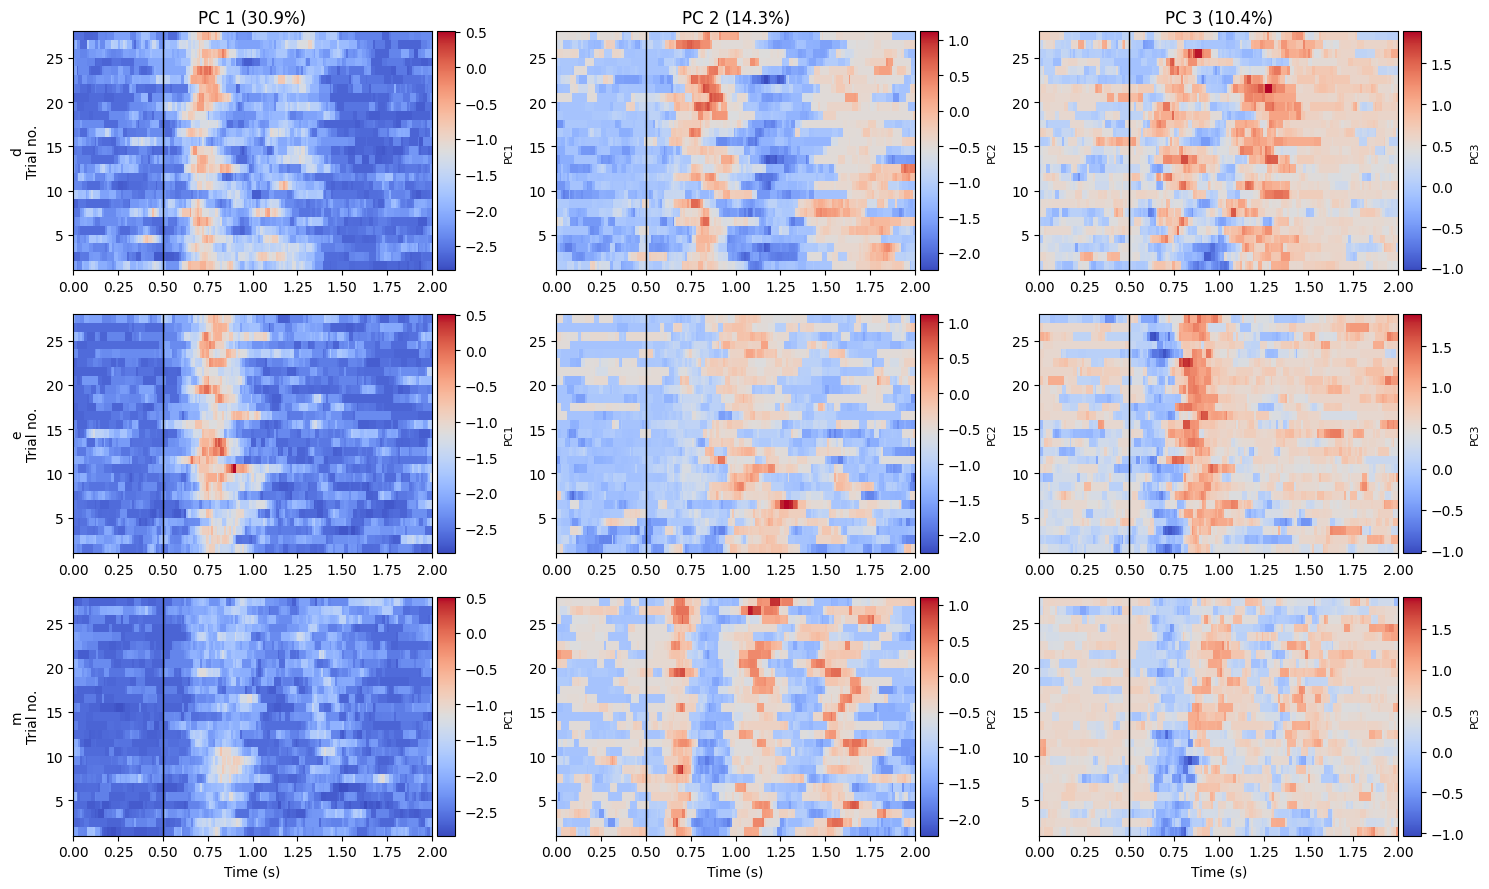

Analysis complete.


In [39]:
import numpy as np
from scipy.ndimage import gaussian_filter1d
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.io as sio

def process_neural_data_for_pca(data_dict, characters):
    """
    Process neural data for PCA visualization, following the original paper's structure.

    Parameters:
    data_dict - Dictionary containing neural data with keys corresponding to different characters
    characters - List of character labels to process

    Returns:
    pc_trajectories - PCA trajectories for each character
    pca_model - Fitted PCA model
    """
    # Constants from the paper
    num_electrodes = 192
    num_time_bins = 200
    num_characters = len(characters)

    # Go cue time step and window definition
    go_cue_bin = 51
    start_bin = go_cue_bin - 50  # -500ms with 10ms bins
    end_bin = start_bin + num_time_bins  # Total 200 bins

    # Step 1: Initialize the N×TC matrix (electrodes × time_bins*characters)
    neural_data_matrix = np.zeros((num_electrodes, num_time_bins * num_characters))

    # Step 2: Process each character
    for c_idx, character in enumerate(characters):
        # Load neural data for this character
        character_data = data_dict[f'neuralActivityCube_{character}']

        # Calculate trial average (assuming dimensions [trials, time, electrodes])
        trial_avg = np.mean(character_data, axis=0)  # [time, electrodes]

        # Extract time window around go cue
        windowed_data = trial_avg[start_bin:end_bin, :]  # [200 bins, 192 electrodes]

        # Apply Gaussian smoothing (SD=30ms = 3 bins)
        smoothed_data = gaussian_filter1d(windowed_data, sigma=3, axis=0)

        # Place in the neural data matrix (rearranging to have electrodes as rows)
        for e in range(num_electrodes):
            col_start = c_idx * num_time_bins
            col_end = (c_idx + 1) * num_time_bins
            neural_data_matrix[e, col_start:col_end] = smoothed_data[:, e]

    # Step 3: Apply PCA to the columns
    pca = PCA(n_components=3)
    pc_scores = pca.fit_transform(neural_data_matrix.T)  # [TC, 3]

    # Step 4: Reshape PC scores for visualization
    pc_trajectories = np.zeros((num_characters, num_time_bins, 3))
    for c in range(num_characters):
        for t in range(num_time_bins):
            idx = c * num_time_bins + t
            pc_trajectories[c, t, :] = pc_scores[idx, :]

    return pc_trajectories, pca

def visualize_pc_trial_heatmaps_independent_scales(data_dict, characters, pca_model, num_trials=27):
    """
    Create heatmap visualization of PC scores over time for each trial with independent color scales.

    Parameters:
    data_dict - Dictionary containing neural data with keys corresponding to different characters
    characters - List of character labels to process
    pca_model - Fitted PCA model
    num_trials - Number of trials to show (maximum)
    """
    # Constants from the original code
    num_time_bins = 200
    go_cue_bin = 51
    start_bin = go_cue_bin - 50  # -500ms with 10ms bins
    end_bin = start_bin + num_time_bins  # Total 200 bins

    # Create figure with subplots - one subplot per character, one column per PC
    num_chars = len(characters)
    num_pcs = 3

    fig, axes = plt.subplots(num_chars, num_pcs, figsize=(15, 3*num_chars),
                            gridspec_kw={'width_ratios': [1] * num_pcs})

    # Handle the case when there's only one character
    if num_chars == 1:
        axes = [axes]

    # Time in seconds (assuming 10ms bins from the original code)
    time_in_sec = np.linspace(0, num_time_bins * 0.01, num_time_bins)

    # Go cue time
    go_cue_time = time_in_sec[50]  # 0.5s if bins are 10ms

    # Process each character
    all_pc_scores = []

    # Process each character to get PC scores
    for c_idx, character in enumerate(characters):
        # Load neural data for this character
        character_data = data_dict[f'neuralActivityCube_{character}']

        # Limit to the number of trials we want to display
        actual_trials = min(character_data.shape[0], num_trials)

        # Initialize array for trial PC scores
        trial_pc_scores = np.zeros((actual_trials, num_time_bins, num_pcs))

        # Process each trial
        for trial in range(actual_trials):
            # Extract time window around go cue for this trial
            trial_data = character_data[trial, start_bin:end_bin, :]  # [200 bins, 192 electrodes]

            # Apply Gaussian smoothing (SD=30ms = 3 bins)
            smoothed_data = gaussian_filter1d(trial_data, sigma=3, axis=0)

            # Project onto PC space
            for t in range(num_time_bins):
                time_point_data = smoothed_data[t, :]
                pc_projection = pca_model.transform([time_point_data])[0]
                trial_pc_scores[trial, t, :] = pc_projection[:num_pcs]

        all_pc_scores.append(trial_pc_scores)

    # Collect all data for each PC separately to calculate independent color scales
    pc_data_by_component = [[] for _ in range(num_pcs)]
    for pc_scores in all_pc_scores:
        for pc_idx in range(num_pcs):
            pc_data_by_component[pc_idx].append(pc_scores[:, :, pc_idx])

    # Calculate min/max for each PC independently
    vmin_by_pc = []
    vmax_by_pc = []
    for pc_idx in range(num_pcs):
        all_data_this_pc = np.concatenate([d.flatten() for d in pc_data_by_component[pc_idx]])
        vmin_by_pc.append(np.min(all_data_this_pc))
        vmax_by_pc.append(np.max(all_data_this_pc))

    # Define colormap
    cmap = plt.cm.coolwarm

    # Create heatmaps for each character and PC
    for c_idx, character in enumerate(characters):
        character_data = data_dict[f'neuralActivityCube_{character}']
        actual_trials = min(character_data.shape[0], num_trials)

        # Get the processed PC scores for this character
        trial_pc_scores = all_pc_scores[c_idx]

        for pc_idx in range(num_pcs):
            if num_chars == 1:
                ax = axes[0][pc_idx]
            else:
                ax = axes[c_idx][pc_idx]

            # Extract data for this PC
            pc_data = trial_pc_scores[:, :, pc_idx]

            # Create heatmap - using PC-specific min/max values
            im = ax.imshow(pc_data, aspect='auto', origin='lower',
                          extent=[time_in_sec[0], time_in_sec[-1], 1, actual_trials+1],
                          cmap=cmap, interpolation='nearest',
                          vmin=vmin_by_pc[pc_idx], vmax=vmax_by_pc[pc_idx])
            # im = plt.imshow(pc_data, aspect='auto', origin='lower', extent=[time_in_sec[0], time_in_sec[-1], 1, actual_trials+1],
            #            cmap=cmap, interpolation='nearest')

            # Add vertical line for go cue
            ax.axvline(x=go_cue_time, color='black', linestyle='-', linewidth=1)

            # Set labels
            if c_idx == 0:
                ax.set_title(f'PC {pc_idx+1}', fontsize=12)

            if pc_idx == 0:
                # Add character label to y-axis
                ax.set_ylabel(f'{character}\nTrial no.', fontsize=10)

            if c_idx == num_chars-1:
                ax.set_xlabel('Time (s)', fontsize=10)

            # Add individual colorbar for each PC
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            cbar = plt.colorbar(im, cax=cax)
            cbar.set_label(f'PC{pc_idx+1}', fontsize=8)

    # Add variance explained if PCA model is provided
    if pca_model is not None and num_chars > 0:
        var_ratios = pca_model.explained_variance_ratio_
        for pc_idx in range(num_pcs):
            if num_chars == 1:
                axes[0][pc_idx].set_title(f'PC {pc_idx+1} ({var_ratios[pc_idx]:.1%})', fontsize=12)
            else:
                axes[0][pc_idx].set_title(f'PC {pc_idx+1} ({var_ratios[pc_idx]:.1%})', fontsize=12)

    plt.tight_layout()
    plt.show()

    return fig

def main():
    try:
        # Try to load data from MATLAB file
        print("Attempting to load data from .mat file...")
        # This line is the problem - you're loading the file twice
        data_dict = sio.loadmat('/content/drive/MyDrive/Emory_Year_2/COMP NEURO/t5.2019.05.08_singleLetters.mat')

        # Extract characters (replace with your actual characters)
        characters = ['d', 'e', 'm']

        print(f"Data loaded successfully. Analyzing characters: {characters}")

    except Exception as e:
        print(f"Error loading data: {e}")
        print("Generating random data for testing...")

        # Generate random test data
        num_trials = 27
        num_time = 300  # Total time bins
        num_electrodes = 192

        data_dict = {}
        characters = ['d', 'e', 'm']

        for char in characters:
            # Generate random data more efficiently
            data = np.random.randn(num_trials, num_time, num_electrodes) * 0.5

            # Add a simulated response pattern more efficiently using vectorization
            for trial in range(num_trials):
                peak_time = 100 + int(np.random.normal(0, 10))
                # Create time array
                t_array = np.arange(num_time)
                # Calculate Gaussian pattern for all time points at once
                gaussian_pattern = 2.0 * np.exp(-0.01 * (t_array - peak_time)**2)
                # Add the pattern to all electrodes for this trial
                for e in range(num_electrodes):
                    data[trial, :, e] += gaussian_pattern

            data_dict[f'neuralActivityCube_{char}'] = data
    # Process the data for PCA
    print("Performing PCA analysis...")
    pc_trajectories, pca_model = process_neural_data_for_pca(data_dict, characters)

    # Create visualization with independent color scales for each PC
    print("Creating visualization...")
    visualize_pc_trial_heatmaps_independent_scales(data_dict, characters, pca_model)

    print("Analysis complete.")
    return pc_trajectories, pca_model

# Run the script when executed directly
if __name__ == "__main__":
    main()

In [27]:
def visualize_pc_heatmaps(pc_trajectories, characters, pca_model=None):
    """
    Create heatmap visualization of PC scores over time for each character.

    Parameters:
    pc_trajectories - PCA trajectories for each character [num_characters, num_time_bins, 3]
    characters - List of character labels
    pca_model - Fitted PCA model (optional, for variance explained)
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.colors import Normalize

    num_characters = len(characters)
    num_time_bins = pc_trajectories.shape[1]
    num_pcs = pc_trajectories.shape[2]  # Should be 3

    # Create figure with subplots - one column per PC
    fig, axes = plt.subplots(1, num_pcs, figsize=(15, 5 + 0.3*num_characters),
                            gridspec_kw={'width_ratios': [1] * num_pcs})

    # Time in seconds (assuming 10ms bins from the original code)
    time_in_sec = np.linspace(0, num_time_bins * 0.01, num_time_bins)

    # Go cue bin (50 in 0-indexed Python, which is at 0.5s if bins are 10ms)
    go_cue_bin = 50
    go_cue_time = time_in_sec[go_cue_bin]

    # Find global min and max PC values for consistent color scaling
    vmin = np.min(pc_trajectories)
    vmax = np.max(pc_trajectories)

    # Define colormap
    cmap = plt.cm.coolwarm

    # Create heatmaps for each PC
    for pc_idx in range(num_pcs):
        ax = axes[pc_idx]

        # Extract data for this PC
        pc_data = np.zeros((num_characters, num_time_bins))
        for c in range(num_characters):
            pc_data[c, :] = pc_trajectories[c, :, pc_idx]

        # Create heatmap
        im = ax.imshow(pc_data, aspect='auto', origin='lower',
                      extent=[time_in_sec[0], time_in_sec[-1], 0, num_characters],
                      cmap=cmap, interpolation='nearest',
                      vmin=vmin, vmax=vmax)

        # Add vertical line for go cue
        ax.axvline(x=go_cue_time, color='black', linestyle='-', linewidth=1)

        # Set labels
        ax.set_title(f'PC {pc_idx+1}', fontsize=14)
        if pc_idx == 0:
            # Only add y-axis labels on the first subplot
            ax.set_yticks(np.arange(0.5, num_characters+0.5))
            ax.set_yticklabels(characters)
            ax.set_ylabel('Character', fontsize=12)
        else:
            # Remove y-ticks from other subplots
            ax.set_yticks([])

        ax.set_xlabel('Time (s)', fontsize=12)

    # Add colorbar to the right of the last subplot
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label('PC Score', fontsize=12)

    # Add labels at the bottom for low/high
    fig.text(0.90, 0.08, 'Low', ha='center', fontsize=10)
    fig.text(0.94, 0.08, 'High', ha='center', fontsize=10)

    # Add variance explained if PCA model is provided
    if pca_model is not None:
        var_ratios = pca_model.explained_variance_ratio_
        for pc_idx in range(num_pcs):
            axes[pc_idx].set_title(f'PC {pc_idx+1} ({var_ratios[pc_idx]:.1%})', fontsize=14)

    plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make room for colorbar
    plt.show()

    return fig

# Modified version to show individual trials instead of character averages
def visualize_pc_trial_heatmaps(data_dict, characters, pca_model=None, num_trials=27):
    """
    Create heatmap visualization of PC scores over time for each trial of each character.

    Parameters:
    data_dict - Dictionary containing neural data with keys corresponding to different characters
    characters - List of character labels to process
    pca_model - Fitted PCA model
    num_trials - Number of trials to show (maximum)
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.colors import Normalize
    from scipy.ndimage import gaussian_filter1d

    # Constants from the original code
    num_electrodes = 192
    num_time_bins = 200
    go_cue_bin = 51
    start_bin = go_cue_bin - 50  # -500ms with 10ms bins
    end_bin = start_bin + num_time_bins  # Total 200 bins

    # Create figure with subplots - one subplot per character, one column per PC
    num_chars = len(characters)
    num_pcs = 3

    fig, axes = plt.subplots(num_chars, num_pcs, figsize=(15, 3*num_chars),
                            gridspec_kw={'width_ratios': [1] * num_pcs})

    # Time in seconds (assuming 10ms bins from the original code)
    time_in_sec = np.linspace(0, num_time_bins * 0.01, num_time_bins)

    # Go cue time
    go_cue_time = time_in_sec[50]  # 0.5s if bins are 10ms

    # Global min/max for consistent color scaling
    all_pc_scores = []

    # Process each character
    for c_idx, character in enumerate(characters):
        # Load neural data for this character
        character_data = data_dict[f'neuralActivityCube_{character}']

        # Limit to the number of trials we want to display
        actual_trials = min(character_data.shape[0], num_trials)

        # Initialize array for trial PC scores
        trial_pc_scores = np.zeros((actual_trials, num_time_bins, num_pcs))

        # Process each trial
        for trial in range(actual_trials):
            # Extract time window around go cue for this trial
            trial_data = character_data[trial, start_bin:end_bin, :]  # [200 bins, 192 electrodes]

            # Apply Gaussian smoothing (SD=30ms = 3 bins)
            smoothed_data = gaussian_filter1d(trial_data, sigma=3, axis=0)

            # Project onto PC space
            for t in range(num_time_bins):
                time_point_data = smoothed_data[t, :]
                pc_projection = pca_model.transform([time_point_data])[0]
                trial_pc_scores[trial, t, :] = pc_projection[:num_pcs]

        all_pc_scores.append(trial_pc_scores)

    # Flatten and find global min/max
    all_pc_scores = np.concatenate(all_pc_scores, axis=0)
    vmin = np.min(all_pc_scores)
    vmax = np.max(all_pc_scores)

    # Define colormap
    cmap = plt.cm.coolwarm

    # Create heatmaps for each character and PC
    for c_idx, character in enumerate(characters):
        character_data = data_dict[f'neuralActivityCube_{character}']
        actual_trials = min(character_data.shape[0], num_trials)

        # Get the processed PC scores for this character
        trial_pc_scores = all_pc_scores[c_idx * actual_trials:(c_idx+1) * actual_trials]

        for pc_idx in range(num_pcs):
            if num_chars == 1:
                ax = axes[pc_idx]
            else:
                ax = axes[c_idx, pc_idx]

            # Extract data for this PC
            pc_data = trial_pc_scores[:, :, pc_idx]

            # Create heatmap
            im = ax.imshow(pc_data, aspect='auto', origin='lower',
                          extent=[time_in_sec[0], time_in_sec[-1], 1, actual_trials+1],
                          cmap=cmap, interpolation='nearest',
                          vmin=vmin, vmax=vmax)

            # Add vertical line for go cue
            ax.axvline(x=go_cue_time, color='black', linestyle='-', linewidth=1)

            # Set labels
            if c_idx == 0:
                ax.set_title(f'PC {pc_idx+1}', fontsize=12)

            if pc_idx == 0:
                # Add character label to y-axis
                ax.set_ylabel(f'{character}\nTrial no.', fontsize=10)

            if c_idx == num_chars-1:
                ax.set_xlabel('Time (s)', fontsize=10)

    # Add colorbar to the right of the last subplot
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label('PC Score', fontsize=12)

    # Add labels at the bottom for low/high
    fig.text(0.90, 0.08, 'Low', ha='center', fontsize=10)
    fig.text(0.94, 0.08, 'High', ha='center', fontsize=10)

    # Add variance explained if PCA model is provided
    if pca_model is not None and num_chars > 0:
        var_ratios = pca_model.explained_variance_ratio_
        for pc_idx in range(num_pcs):
            if num_chars == 1:
                axes[pc_idx].set_title(f'PC {pc_idx+1} ({var_ratios[pc_idx]:.1%})', fontsize=12)
            else:
                axes[0, pc_idx].set_title(f'PC {pc_idx+1} ({var_ratios[pc_idx]:.1%})', fontsize=12)

    plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make room for colorbar
    plt.show()

    return fig

# Update the main function to use the new visualizations
def main(data_dict, characters):
    # Process the data
    pc_trajectories, pca_model = process_neural_data_for_pca(data_dict, characters)

    # Create visualization of character averages
    visualize_pc_heatmaps(pc_trajectories, characters, pca_model)

    # Create visualization of individual trials
    visualize_pc_trial_heatmaps(data_dict, characters, pca_model)

    return pc_trajectories, pca_model

<ipython-input-27-5d8b6116df88>:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make room for colorbar


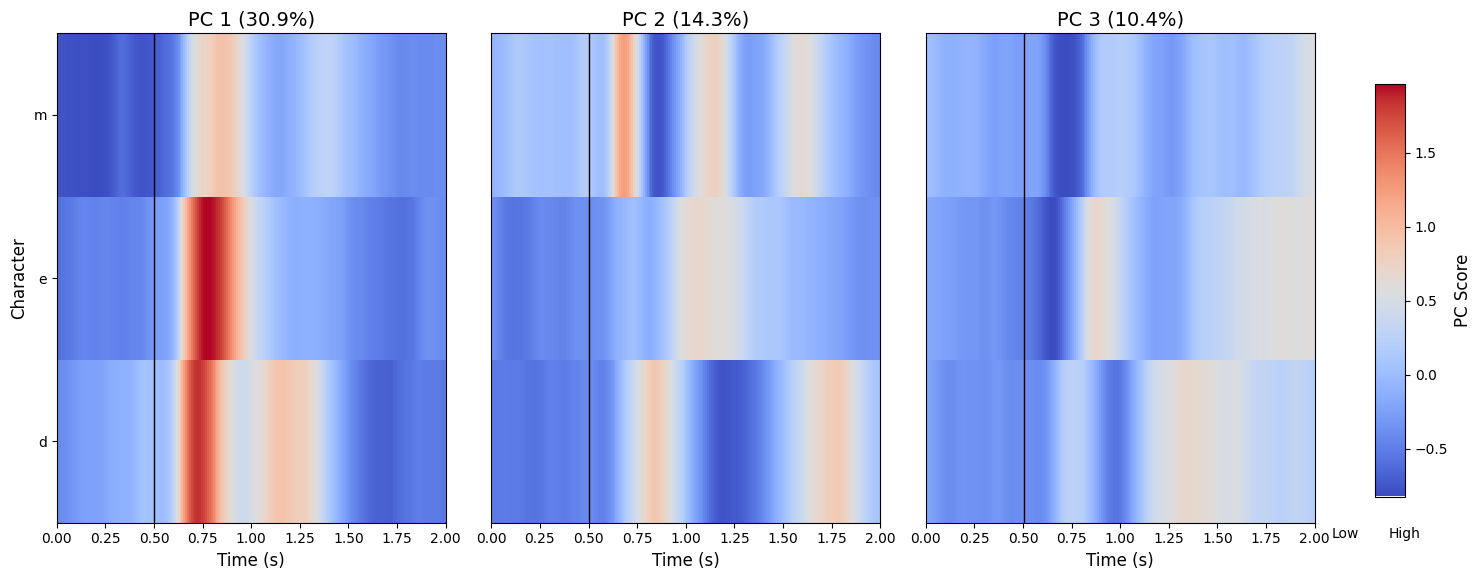

NameError: name 'data' is not defined

In [30]:
import scipy.io as sio
import matplotlib.pyplot as plt

# Load your data
dat = scipy.io.loadmat('/content/drive/MyDrive/Emory_Year_2/COMP NEURO/t5.2019.05.08_singleLetters.mat')

# Define which characters to analyze
characters = ['d', 'e', 'm']  # Replace with your desired letters

# Process data and create PCA trajectories
pc_trajectories, pca_model = process_neural_data_for_pca(dat, characters)

# Create heatmap visualization
visualize_pc_heatmaps(pc_trajectories, characters, pca_model)

# Create trial-by-trial visualization
# visualize_pc_trial_heatmaps(data, characters, pca_model)

plt.show()

Warping character: a


<ipython-input-10-50ffd5adf7d6>:41: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['normalized_neuralActivityCube_' + char], 3.0, axis = 1)
Loss improvement: 8.00%: 100%|██████████| 50/50 [01:09<00:00,  1.40s/it]
<ipython-input-10-50ffd5adf7d6>:49: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  smoothed_agligned_data = scipy.ndimage.filters.gaussian_filter1d(estimated_aligned_data, 3.0, axis = 1)


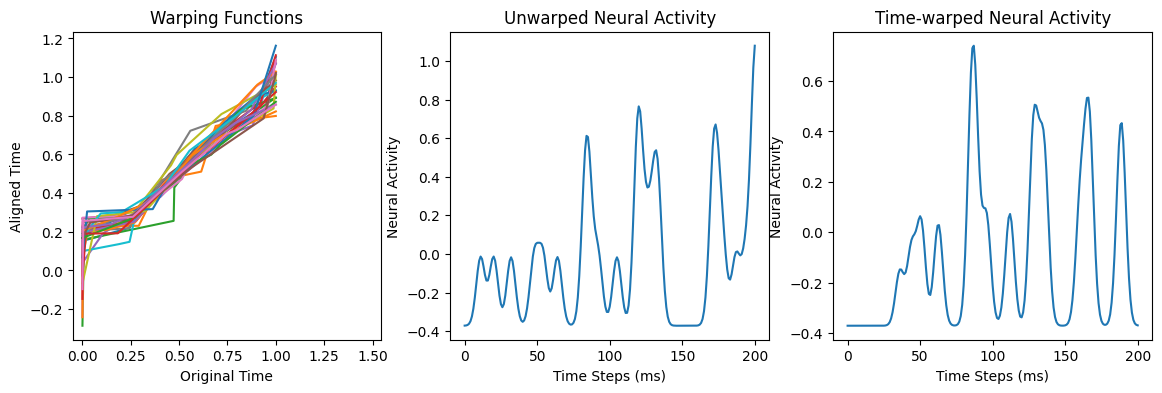

<ipython-input-10-50ffd5adf7d6>:41: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['normalized_neuralActivityCube_' + char], 3.0, axis = 1)


Warping character: b


Loss improvement: 9.29%: 100%|██████████| 50/50 [00:50<00:00,  1.01s/it]


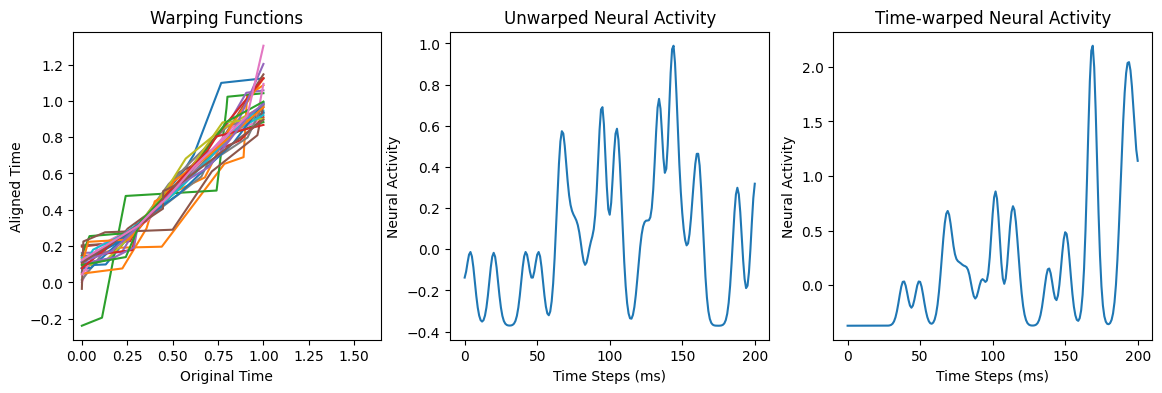

Warping character: c


Loss improvement: 8.76%: 100%|██████████| 50/50 [00:52<00:00,  1.06s/it]


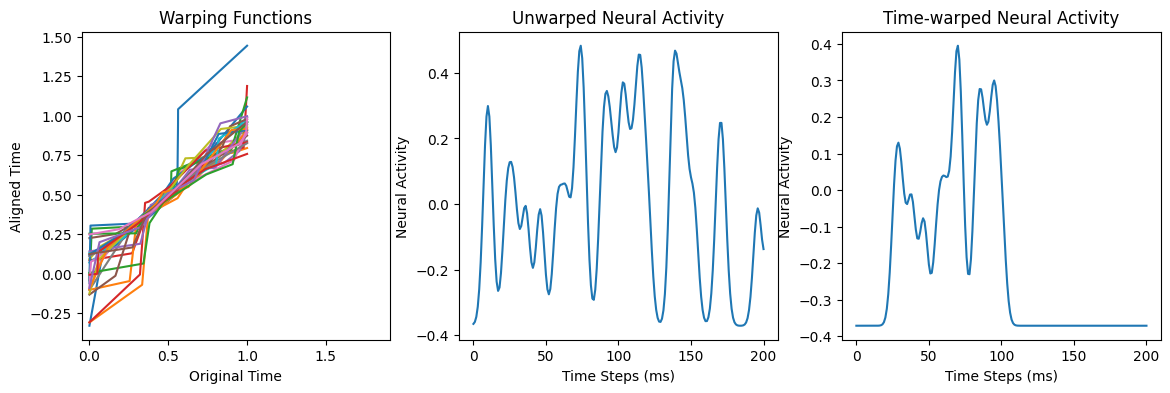

Warping character: d


Loss improvement: 8.79%: 100%|██████████| 50/50 [00:57<00:00,  1.16s/it]


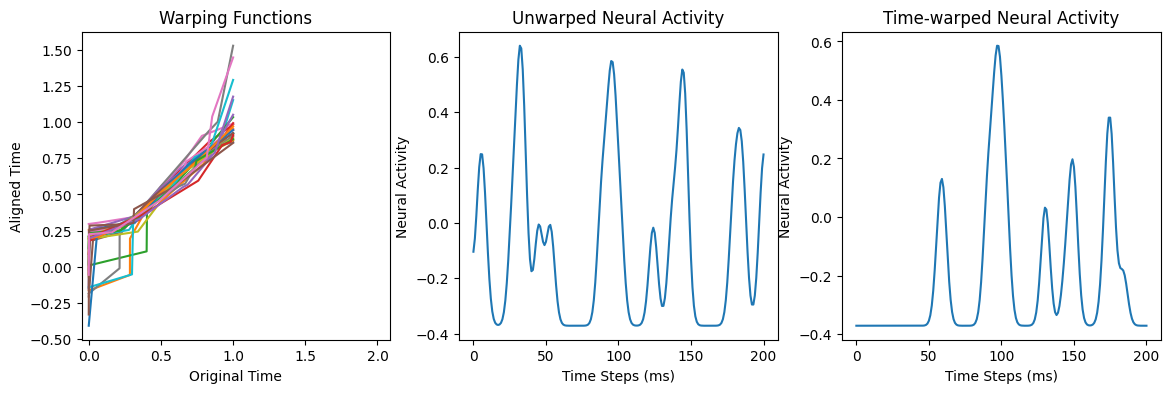

Warping character: e


Loss improvement: 9.03%: 100%|██████████| 50/50 [00:49<00:00,  1.01it/s]


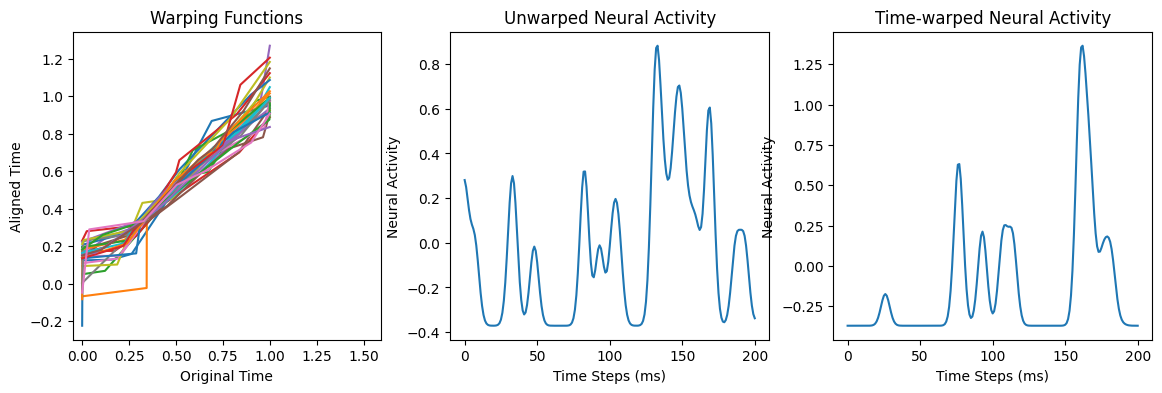

Warping character: f


Loss improvement: 9.59%: 100%|██████████| 50/50 [00:50<00:00,  1.02s/it]


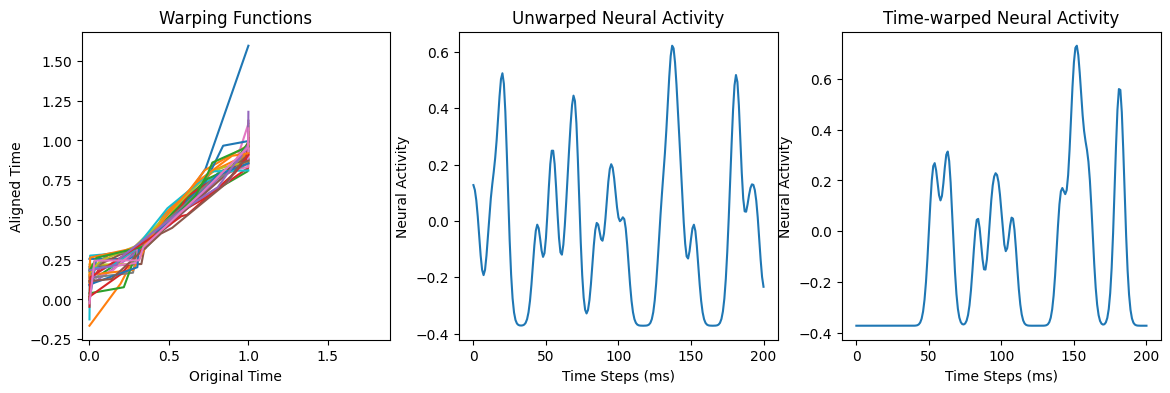

Warping character: g


Loss improvement: 7.40%:   6%|▌         | 3/50 [00:04<01:13,  1.57s/it]


KeyboardInterrupt: 

In [10]:
# Time-warping the single letters data cont'd: VERY SLOW (~23 mins on my end)

# defines the list of all 31 characters and what to call then
charDef = getHandwritingCharacterDefinitions()

# Pre-processing and Normalizing
# Because baseline firing rates drift over time, we normalize each electrode's firing rate by subtracting its mean firing rate within each block of data (re-centering it).
# We also divide by each electrode's standard deviation to normalize the units.

for char in charDef['charList']:
    neuralCube = dat['neuralActivityCube_' + char].astype(np.float64)

    # get the trials that belong to this character
    trlIdx = []
    for t in range(dat['characterCues'].shape[0]):
      if dat['characterCues'][t,0] == char:
        trlIdx.append(t)
    # get the block that each trial
    blockIdx = dat['blockNumsTimeSeries'][dat['goPeriodOnsetTimeBin'][trlIdx]]
    blockIdx = np.squeeze(blockIdx)

    # subtract block-specific means from each trial
    for b in range(dat['blockList'].shape[0]):
      trialsFromThisBlock = np.squeeze(blockIdx == dat['blockList'][b])
      neuralCube[trialsFromThisBlock, :, :] -= dat['meansPerBlock'][np.newaxis, b, :]

    # divide by standard deviation to normalize the units
    neuralCube = neuralCube / dat['stdAcrossAllData'][np.newaxis, :, :]

    # save the normalized neural cube in the same dataset
    dat['normalized_neuralActivityCube_' + char] = neuralCube

# Warp each character

alignedDat = {}

for char in charDef['charList']:
    print('Warping character: ' + char)

    # smooths the binned spike counts before time-warping to denoise them
    smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['normalized_neuralActivityCube_' + char], 3.0, axis = 1)

    # fit the piecewise-affine time warping model
    model = PiecewiseWarping(n_knots = 5, warp_reg_scale = 0.01, smoothness_reg_scale = 0.01)
    model.fit(smoothed_spikes)

    # use the model object to align data
    estimated_aligned_data = model.transform(dat['normalized_neuralActivityCube_' + char])
    smoothed_agligned_data = scipy.ndimage.filters.gaussian_filter1d(estimated_aligned_data, 3.0, axis = 1)

    # store aligned data and time-warping functions
    alignedDat[char] = estimated_aligned_data
    alignedDat[char + '_xknots'] = model.x_knots.T
    alignedDat[char + '_yknots'] = model.y_knots.T

    # extract trial traces by selecting one specific electrode just for visualization, ie: electrode 45 in this case
    unwarped_trace = smoothed_spikes[0, :, 45]
    warped_trace = smoothed_agligned_data[0, :, 45]

    # plot the warping functions
    plt.figure(figsize = (14,4))
    plt.subplot(1,3,1)
    plt.plot(model.x_knots.T, model.y_knots.T)
    plt.axis('square')
    plt.xlabel('Original Time')
    plt.ylabel('Aligned Time')
    plt.title('Warping Functions')

    # plot the unwarped data
    plt.subplot(1,3,2)
    plt.plot(unwarped_trace, label = 'Unwarped')
    plt.title("Unwarped Neural Activity")
    plt.xlabel("Time Steps (ms)")
    plt.ylabel("Neural Activity")

    # plot the warped data
    plt.subplot(1,3,3)
    plt.plot(warped_trace)
    plt.title("Time-warped Neural Activity")
    plt.xlabel("Time Steps (ms)")
    plt.ylabel("Neural Activity")

    plt.show()

# Save time-warped data
scipy.io.savemat('/content/drive/MyDrive/Emory_Year_2/COMP NEURO/t5.2019.05.08_warpedCubes.mat', alignedDat)
